Target:```To reduce the parameters and check whether the model gives similar kind of performance with just changing the number of kernels which will in turn reduce the number of parameters.```

Result: ```The accuracy is same as the previous one 99.13 as the highest accuracy ```


Analysis: ``````Looks like model is training the right way .No overfitting issue just like the previous notebook if trained for more epochs ,it will denitely cross 99.4 accuracy but there is some issue with learning rate scheduler ``````

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(degrees=(-10,10), resample=False, expand=False, center=None, fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [9]:
train_loader

In [10]:
print(test.data.shape,train.data.shape)


torch.Size([10000, 28, 28]) torch.Size([60000, 28, 28])


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [11]:
train.data.shape

torch.Size([60000, 28, 28])

# The model
Let's start with the model we first saw

In [12]:
class conv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=(3,3),dropout=0.1,**kwargs):
    super(conv_block, self).__init__()
    self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,**kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
    # self.out_channels=out_channels
  def forward(self,x):
    return self.convblock(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1=conv_block(in_channels=1,out_channels=16,padding=0)
        self.conv2=conv_block(in_channels=16,out_channels=16,padding=0)
        
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.conv3=conv_block(in_channels=16,out_channels=10,padding=0,kernel_size=(1,1))
        
        self.conv4=conv_block(in_channels=10,out_channels=16,padding=0)
        self.conv5=conv_block(in_channels=16,out_channels=16,padding=0)
        
        self.conv6=conv_block(in_channels=16,out_channels=10,dropout=0.0,padding=0)
#         self.conv7=conv_block(in_channels=14,out_channels=10,dropout=0.0,kernel_size=(5,5),padding=0)
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )
        self.fc1=nn.Linear(10,10)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.pool1(x)
        x= self.conv3(x)
        x= self.conv4(x)
        x= self.conv5(x)
        x= self.conv6(x)
        x= self.gap(x)
        x = x.view(-1, 10)
        x=self.fc1(x)

#         x=self.conv8(x)
        
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
        conv_block-5           [-1, 16, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           2,320
       BatchNorm2d-7           [-1, 16, 24, 24]              32
              ReLU-8           [-1, 16, 24, 24]               0
           Dropout-9           [-1, 16, 24, 24]               0
       conv_block-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 10, 12, 12]             170
      BatchNorm2d-13           [-1, 10, 12, 12]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [14]:
from tqdm import tqdm_notebook,tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader,position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # print(data.shape)
    # Init
    # scheduler.step()
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    # scheduler.step()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    # print(f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
model =  Net().to(device)

# Let's Train and test our model

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):

    print(f"EPOCH = {epoch}")
    
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH = 0


Loss=0.15522755682468414 Batch_id=468 Accuracy=74.37: 100%|██████████| 469/469 [00:04<00:00, 109.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1554, Accuracy: 9660/10000 (96.60%)

EPOCH = 1


Loss=0.09966225177049637 Batch_id=468 Accuracy=95.79: 100%|██████████| 469/469 [00:04<00:00, 105.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9809/10000 (98.09%)

EPOCH = 2


Loss=0.08130881935358047 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:04<00:00, 100.53it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9826/10000 (98.26%)

EPOCH = 3


Loss=0.11577258259057999 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:04<00:00, 99.70it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9821/10000 (98.21%)

EPOCH = 4


Loss=0.06663567572832108 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:04<00:00, 97.05it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9864/10000 (98.64%)

EPOCH = 5


Loss=0.04155777394771576 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:04<00:00, 93.85it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9851/10000 (98.51%)

EPOCH = 6


Loss=0.17347455024719238 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:05<00:00, 88.78it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9864/10000 (98.64%)

EPOCH = 7


Loss=0.050126221030950546 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:05<00:00, 85.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9887/10000 (98.87%)

EPOCH = 8


Loss=0.13354726135730743 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:05<00:00, 84.54it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9873/10000 (98.73%)

EPOCH = 9


Loss=0.023738810792565346 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:05<00:00, 81.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9904/10000 (99.04%)

EPOCH = 10


Loss=0.06801096349954605 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:06<00:00, 76.21it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9894/10000 (98.94%)

EPOCH = 11


Loss=0.017502397298812866 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:05<00:00, 82.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9915/10000 (99.15%)

EPOCH = 12


Loss=0.05450601503252983 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:06<00:00, 73.22it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

EPOCH = 13


Loss=0.05770789086818695 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:06<00:00, 69.94it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9904/10000 (99.04%)

EPOCH = 14


Loss=0.032345015555620193 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:05<00:00, 80.55it/s]



Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)



In [0]:
optimizer

In [0]:
model(images.cuda()).shape

torch.Size([1152, 10])

Text(0.5, 1.0, 'Test Accuracy')

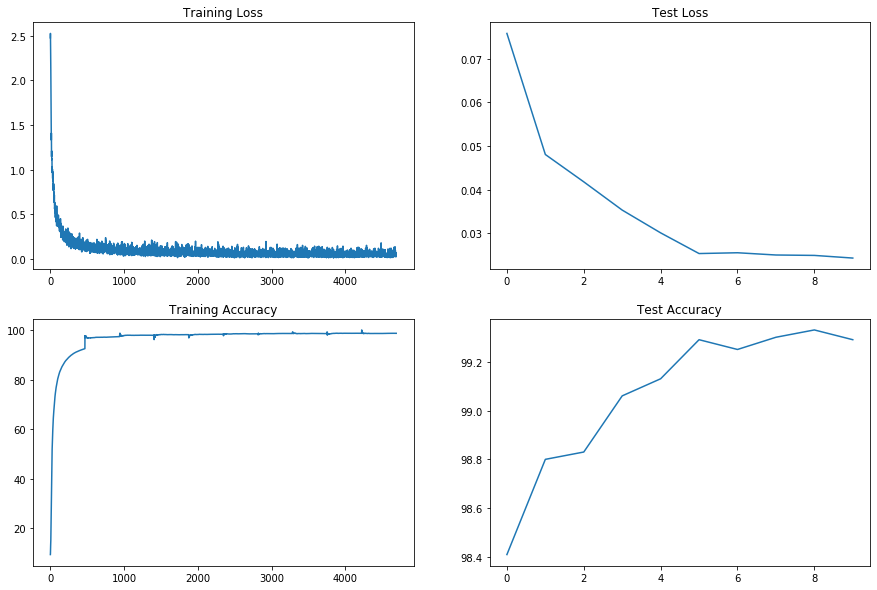

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")